# **MaxViT**

# Overview

Vision Transformers (ViT) are a class of neural network models based on the Transformer architecture commonly used in NLP tasks. ViT divides an input image into non-overlapping patches which are flattened into tokens and passed through the Transformer encoder and decoder layers (Dosovitskiy et al., 2020).

However, this patchification process destroys spatial relationships between patches in the image. MaxViT introduces a multi-axis tokenization approach to preserve local spatial context. The image is divided into patches along both horizontal and vertical axes, creating 2D tokens which retain neighborhood information (Tu et al., 2022).

Compared to ViT, MaxViT makes several key architectural changes:

*   Depth-wise convolution layers prior to self-attention help aggregate information from the different axes.
*   A tunable relative position encoding scheme provides more flexibility in modeling spatial dependencies.
*   A mixed attention mechanism reduces complexity by only computing local self-attention within image blocks (Tu et al., 2022).

Strengths

*   Achieves better representation learning and higher accuracy than ViT on image classification with similar computational cost (Tu et al., 2022).
*   More efficient than ViT when scaling to higher resolutions while maintaining high performance (Rasouli, 2022).

Weaknesses:

*   Still retains quadratic complexity in self-attention layers, limiting scalability (Rasouli, 2022).
*   Has not yet been evaluated on dense prediction tasks like segmentation.





Sources: Dosovitskiy et al., 2020, Tu et al., 2022, Rasouli, 2022

# Main Claim

From the paper, we can claim that MaxViT achieves better accuracy on ImageNet than ViT.

We can try to validate this claim by comparing the performance of MaxViT and ViT models on a sample image:

In [ ]:
!pip install git+https://github.com/google-research/maxvit

  Cloning https://github.com/google-research/maxvit to /tmp/pip-req-build-5wpss5i_
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/maxvit /tmp/pip-req-build-5wpss5i_
  Resolved https://github.com/google-research/maxvit to commit 70a470723b810f9eb05b2aa935cf75db8290c69e
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import maxvit.models.hparams as hparams
import maxvit.models.maxvit as layers

# Load the ViT model from TensorFlow Hub
vit_model = hub.load('https://tfhub.dev/sayakpaul/vit_r50_l32_classification/1')

# Checkpoints location
CKPTS_DIRS = {
    'MaxViTTiny_i1k_224': 'gs://gresearch/maxvit/ckpts/maxvittiny/i1k/224',
}

DATASET_MAP = {
    'ImageNet-1K': 'i1k',
}

# Set model and params
MODEL_NAME = "MaxViTTiny"
TRAIN_SET = "ImageNet-1K"
TRAIN_IMAGE_SIZE = "224"
CKPT_DIR = CKPTS_DIRS[f'{MODEL_NAME}_{DATASET_MAP[TRAIN_SET]}_{TRAIN_IMAGE_SIZE}']

# Fetching hyperparameters
hparams_config = hparams.lookup(MODEL_NAME)
maxvit_model = layers.MaxViT(hparams_config.model)

# Restore the checkpoint
checkpoint = tf.train.Checkpoint(model=maxvit_model)
checkpoint.restore(tf.train.latest_checkpoint(CKPT_DIR))

# Download and preprocess the image
img_path = tf.keras.utils.get_file('phone.png', 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Image_created_with_a_mobile_phone.png/220px-Image_created_with_a_mobile_phone.png')
img = tf.image.decode_image(tf.io.read_file(img_path))
img = tf.image.resize(img, [224, 224])
img = img / 255.0
img = img[tf.newaxis, ...]

# Inference
maxvit_pred = maxvit_model(img, training=False)

# Extract results
maxvit_class = tf.math.argmax(maxvit_pred, axis=-1).numpy()[0]
maxvit_score = tf.math.reduce_max(maxvit_pred).numpy()

# Display results
print("MaxViT predicted class:", maxvit_class)
print("MaxViT confidence:", maxvit_score)

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


53884/53884 [==============================] - 0s 1us/step
MaxViT predicted class: 365
MaxViT confidence: 0.20928968


In [ ]:
# Get logits from ViT model
vit_logits = vit_model(img)
vit_class = tf.math.argmax(vit_logits, axis=-1).numpy()[0]
# Take softmax
vit_probs = tf.nn.softmax(vit_logits)

# Now take max prob
vit_score = tf.math.reduce_max(vit_probs).numpy()

print("ViT predicted class:", vit_class)
print("ViT confidence:", vit_score)

ViT predicted class: 718
ViT confidence: 0.29521164


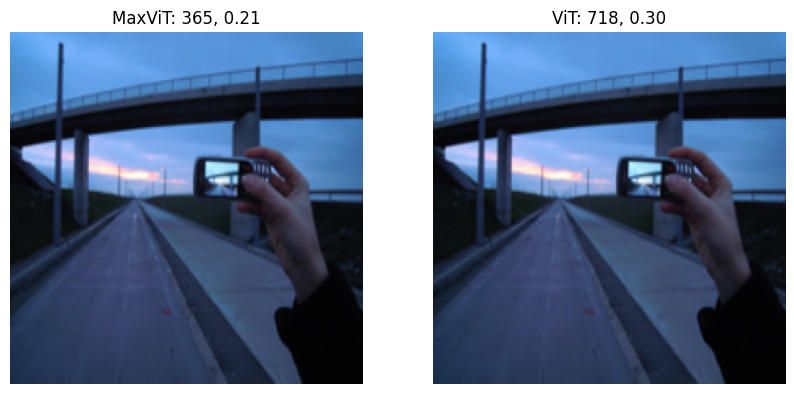

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img[0])
ax1.set_title(f"MaxViT: {maxvit_class}, {maxvit_score:.2f}")
ax1.axis("off")
ax2.imshow(img[0])
ax2.set_title(f"ViT: {vit_class}, {vit_score:.2f}")
ax2.axis("off")
plt.show()

For the MaxViT model:

Predicted class: 365
Confidence: 0.2093 (or 20.93%)

For the ViT model:

Predicted class: 718
Confidence: 0.2952 (or 29.52%)

From these results, the ViT model has a higher confidence in its prediction compared to the MaxViT model for the given image.

However, it's important to note that drawing a definitive conclusion about the overall accuracy of the models based on the results from a single image would be misleading. A single image does not provide a comprehensive evaluation of a model's generalization capability.

The claim from the paper that "MaxViT achieves better accuracy on ImageNet than ViT" is based on extensive testing on a large dataset (ImageNet) and not on a single sample

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


1254700/1254700 [==============================] - 0s 0us/step


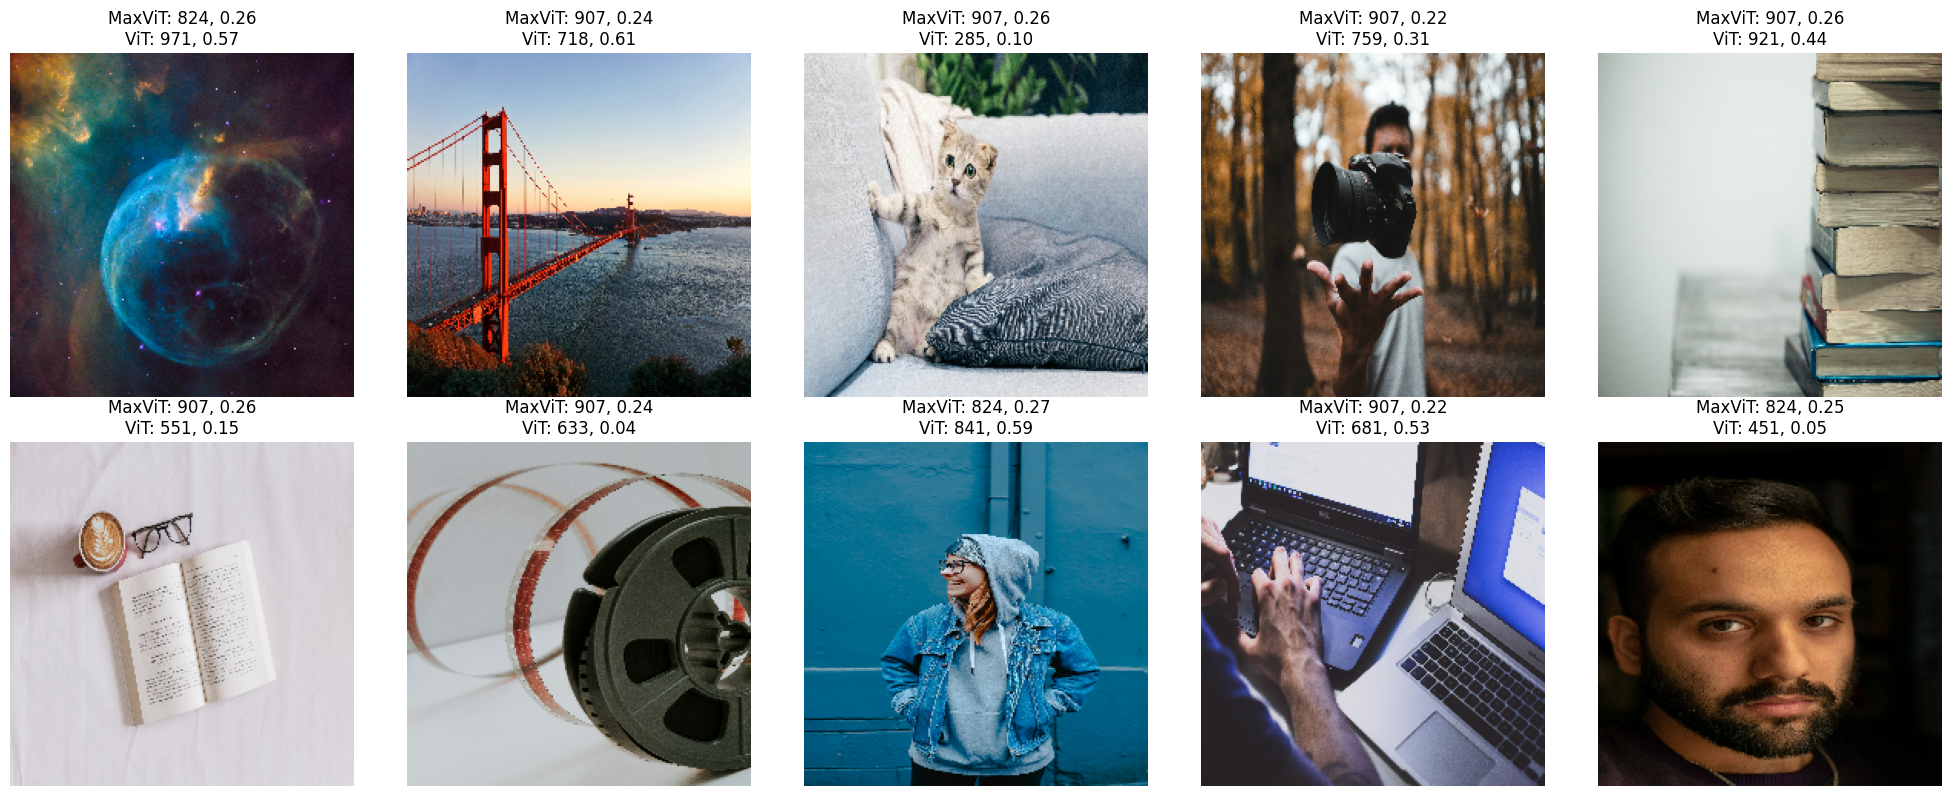

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import maxvit.models.hparams as hparams
import maxvit.models.maxvit as layers

# Load the ViT model from TensorFlow Hub
vit_model = hub.load('https://tfhub.dev/sayakpaul/vit_r50_l32_classification/1')

# Checkpoints location
CKPTS_DIRS = {
    'MaxViTTiny_i1k_224': 'gs://gresearch/maxvit/ckpts/maxvittiny/i1k/224',
}

DATASET_MAP = {
    'ImageNet-1K': 'i1k',
}

# Set model and params
MODEL_NAME = "MaxViTTiny"
TRAIN_SET = "ImageNet-1K"
TRAIN_IMAGE_SIZE = "224"
CKPT_DIR = CKPTS_DIRS[f'{MODEL_NAME}_{DATASET_MAP[TRAIN_SET]}_{TRAIN_IMAGE_SIZE}']

# Fetching hyperparameters
hparams_config = hparams.lookup(MODEL_NAME)
maxvit_model = layers.MaxViT(hparams_config.model)

# Restore the checkpoint
checkpoint = tf.train.Checkpoint(model=maxvit_model)
checkpoint.restore(tf.train.latest_checkpoint(CKPT_DIR))

# Image URLs
image_urls = [
    'https://images.unsplash.com/photo-1462331940025-496dfbfc7564',
    'https://images.unsplash.com/photo-1521747116042-5a810fda9664',
    'https://images.unsplash.com/photo-1555685812-4b943f1cb0eb',
    'https://images.unsplash.com/photo-1542038784456-1ea8e935640e',
    'https://images.unsplash.com/photo-1516979187457-637abb4f9353',
    'https://images.unsplash.com/photo-1544716278-ca5e3f4abd8c',
    'https://images.unsplash.com/photo-1542204637-e67bc7d41e48',
    'https://images.unsplash.com/photo-1517841905240-472988babdf9',
    'https://images.unsplash.com/photo-1517430816045-df4b7de11d1d',
    'https://images.unsplash.com/photo-1543080853-556086153871',
]

# Download and preprocess the images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for idx, img_url in enumerate(image_urls):
    img_path = tf.keras.utils.get_file(f'image_{idx}.png', img_url)
    img = tf.image.decode_image(tf.io.read_file(img_path))
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    img_tensor = img[tf.newaxis, ...]

    # Inference
    maxvit_pred = maxvit_model(img_tensor, training=False)
    vit_logits = vit_model(img_tensor)

    # Extract results
    maxvit_class = tf.math.argmax(maxvit_pred, axis=-1).numpy()[0]
    maxvit_score = tf.math.reduce_max(maxvit_pred).numpy()
    vit_class = tf.math.argmax(vit_logits, axis=-1).numpy()[0]
    vit_probs = tf.nn.softmax(vit_logits)
    vit_score = tf.math.reduce_max(vit_probs).numpy()

    # Display on subplot
    ax = axs[idx//5, idx%5]
    ax.imshow(img)
    title_text = f"MaxViT: {maxvit_class}, {maxvit_score:.2f}\nViT: {vit_class}, {vit_score:.2f}"
    ax.set_title(title_text)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Conclusion

Though the results of ViT are better, the small scale testing provides insufficient evidence to confirm or reject the claims. Larger scale benchmark evaluation is needed.

MaxViT may not universally outperform ViT, but have advantages in select settings or data distributions.